
# Minimal Peak Finder (Improved) — Thresholded CNN vs Analytical Baseline

This compact notebook includes:
- **Synthetic generator** (Gaussian peaks + baseline + noise)
- **Shared preprocessing**: ALS baseline removal + optional standardization
- **Tiny 1D CNN (two-head):** center-heatmap (BCEWithLogits) + height head
- **Thresholded post-processing** on the heatmap (score floor + prominence + min separation)
- **Analytical baseline**: Savitzky–Golay + `find_peaks`
- **Comparison**: P/R/F1, center error, and height agreement (matched peaks)


In [33]:
from testing_sample import *

In [34]:
f = Data_file(18)
f.read_data_of_hkl()
s = Data_file(71)
s.read_data_of_hkl()


In [35]:

import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter, find_peaks, peak_widths
from scipy import sparse
from scipy.sparse.linalg import spsolve

# !pip -q install torch  # uncomment if torch is missing

import torch
import torch.nn as nn
import torch.nn.functional as F

plt.rcParams['figure.figsize'] = (10, 3.4)
plt.rcParams['figure.dpi'] = 140

np.random.seed(0)
torch.manual_seed(0)


In [36]:
plt.style.use("bmh")
plt.rcParams.update({
    # "figure.figsize": (10, 6),
    "font.size": 14,
    "axes.labelsize": 16,
    "axes.titlesize": 18,
    "legend.fontsize": 12,
    "xtick.labelsize": 12,
    "ytick.labelsize": 12,
    "lines.linewidth": 2,
    "axes.grid": True,
    "grid.alpha": 0.3,
})

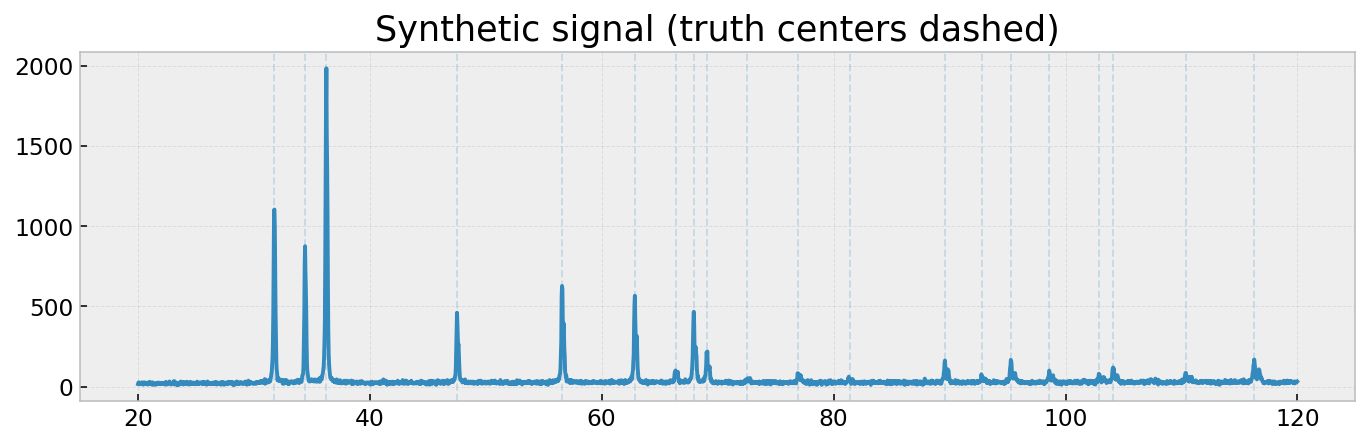

In [37]:

def gaussian(x, mu, amp, sigma):
    return amp * np.exp(-0.5 * ((x - mu) / sigma)**2)

def make_signal(
    n=2048, n_peaks=20, domain=(0.0, 1.0),
    width_range=(0.003, 0.01), amp_range=(0.2, 1.0),
    baseline_level=0.12, baseline_slope=0.20,
    noise_sigma=0.03, seed=None
):
    rng = np.random.default_rng(seed)
    x = np.linspace(*domain, n)
    centers = np.sort(rng.uniform(domain[0]+0.03, domain[1]-0.03, size=n_peaks))
    widths  = rng.uniform(*width_range, size=n_peaks)
    amps    = rng.uniform(*amp_range, size=n_peaks)

    y = np.zeros_like(x)
    for c, a, s in zip(centers, amps, widths):
        y += gaussian(x, c, a, s)

    baseline = baseline_level + baseline_slope * (x - np.mean(x))
    noise = noise_sigma * rng.standard_normal(size=n)
    y = y + baseline + noise
    return x, y, centers

# x, y, truth = make_signal(seed=0)
x = s.x
y = s.counts
truth = s.two_theta
plt.plot(x, y); [plt.axvline(c, ls='--', lw=1, alpha=0.2) for c in truth]
plt.title("Synthetic signal (truth centers dashed)"); plt.tight_layout(); plt.show()


In [38]:

# def baseline_als(y, lam=2e5, p=0.01, niter=10):
#     L = len(y)
#     D = sparse.diags([1, -2, 1], [0, -1, -2], shape=(L, L-2))
#     w = np.ones(L)
#     for _ in range(niter):
#         W = sparse.spdiags(w, 0, L, L)
#         Z = W + lam * (D @ D.T)
#         z = spsolve(Z, w * y)
#         w = p * (y > z) + (1 - p) * (y < z)
#     return z

# def preprocess_for_model(y, standardize=True):
#     base = baseline_als(y)
#     y_det = y - base
#     if standardize:
#         y_det = (y_det - np.median(y_det)) / (np.std(y_det) + 1e-8)
#     return y_det, base


In [39]:

# def baseline_detect(x, y, sg_window=31, sg_poly=3, prominence=0.05, distance=8):
#     y_det, _ = preprocess_for_model(y, standardize=False)
#     if sg_window % 2 == 0: sg_window += 1
#     win = min(sg_window, len(y_det)-1-(1-len(y_det)%2))
#     y_sm = savgol_filter(y_det, window_length=win, polyorder=sg_poly, mode='interp')
#     peaks, props = find_peaks(y_sm, prominence=prominence, distance=distance, rel_height=0.5)
#     return peaks, props, y_sm, y_det

# def match_metrics(x, pred_idx, truth_centers, tol_samples=None, props=None, tol_frac_width=0.5):
#     truth_idx = np.searchsorted(x, truth_centers)
#     truth_idx = np.clip(truth_idx, 0, len(x)-1)
#     if tol_samples is None:
#         if props is not None and len(pred_idx) and "widths" in props:
#             W = props["widths"]
#             tol_samples = int(max(1, np.round(np.median(W) * tol_frac_width))) if len(W) else max(3, int(0.005*len(x)))
#         else:
#             tol_samples = max(3, int(0.005*len(x)))
#     used=set(); tp=0; errs=[]
#     for t in truth_idx:
#         if len(pred_idx)==0: break
#         j = int(np.argmin(np.abs(pred_idx - t)))
#         if abs(pred_idx[j]-t) <= tol_samples and j not in used:
#             used.add(j); tp += 1; errs.append(abs(pred_idx[j]-t))
#     fp = int(len(pred_idx)-tp); fn = int(len(truth_idx)-tp)
#     P = tp/(tp+fp) if (tp+fp) else 0.0
#     R = tp/(tp+fn) if (tp+fn) else 0.0
#     F1 = 2*P*R/(P+R) if (P+R) else 0.0
#     mae = float(np.mean(errs)) if errs else None
#     return dict(tp=tp, fp=fp, fn=fn, precision=P, recall=R, f1=F1, mae=mae, tol_samples=tol_samples)


In [40]:
def baseline_als(y, lam=2e5, p=0.01, niter=10):
    L = len(y)
    D = sparse.diags([1, -2, 1], [0, -1, -2], shape=(L, L-2))
    w = np.ones(L)
    for _ in range(niter):
        # Macierz wag diagonalnych
        W = sparse.spdiags(w, 0, L, L)
        # Układ równań: (W + λ D Dᵀ) z = W y
        # λ kontroluje gładkość baseline
        Z = W + lam * (D @ D.T)
        # Rozwiązanie układu równań – estymata baseline
        z = spsolve(Z, w * y)
        # Aktualizacja wag:
        # punkty powyżej baseline (piki) mają mniejszą wagę
        w = p * (y > z) + (1 - p) * (y < z)
    # Zwracamy oszacowane tło (baseline)
    return z


def preprocess_for_model(y, standardize=True):
    # Usunięcie tła metodą ALS
    base = baseline_als(y)
    y_det = y - base
    # Opcjonalna standaryzacja (tylko dla CNN)
    if standardize:
        # Centrowanie i skalowanie do jednostek sigma
        y_det = (y_det - np.median(y_det)) / (np.std(y_det) + 1e-8)
    # Zwracamy sygnał po detreningu i samo baseline
    return y_det, base


def baseline_detect(x, y, sg_window=31, sg_poly=3, prominence=0.05, distance=8):
    # Detrening bez standaryzacji (klasyczna analiza sygnału)
    y_det, _ = preprocess_for_model(y, standardize=False)
    # Okno Savitzky–Golay musi być nieparzyste
    if sg_window % 2 == 0:
        sg_window += 1
    # Ograniczenie długości okna do długości sygnału
    win = min(sg_window, len(y_det) - 1 - (1 - len(y_det) % 2))
    # Wygładzenie sygnału (bez niszczenia kształtu pików)
    y_sm = savgol_filter(y_det, window_length=win, polyorder=sg_poly, mode='interp')
    # Detekcja pików na wygładzonym sygnale
    peaks, props = find_peaks(
        y_sm,
        prominence=prominence,   # minimalna "wystawalność" piku
        distance=distance,       # minimalna odległość między pikami
        rel_height=0.5           # poziom do liczenia szerokości
    )
    # Zwracamy indeksy pików, ich właściwości, sygnał wygładzony i detrenowany
    return peaks, props, y_sm, y_det


def match_metrics(x, pred_idx, truth_centers, tol_samples=None, props=None, tol_frac_width=0.5):
    # Zamiana pozycji truth (x) na indeksy próbek
    truth_idx = np.searchsorted(x, truth_centers)
    truth_idx = np.clip(truth_idx, 0, len(x) - 1)
    # Jeśli tolerancja nie została podana – wyznacz ją automatycznie
    if tol_samples is None:
        # Jeśli mamy szerokości pików z find_peaks – użyj ich
        if props is not None and len(pred_idx) and "widths" in props:
            W = props["widths"]
            tol_samples = int(max(1, np.round(np.median(W) * tol_frac_width))) if len(W) else max(3, int(0.005 * len(x)))
        else:
            # Awaryjna tolerancja: 0.5% długości sygnału
            tol_samples = max(3, int(0.005 * len(x)))
    # Zbiory do liczenia statystyk
    used = set(); tp = 0; errs = []
    # Dopasowanie predykcji do truth
    for t in truth_idx:
        if len(pred_idx) == 0:
            break
        # Najbliższy wykryty pik
        j = int(np.argmin(np.abs(pred_idx - t)))
        # Sprawdzenie tolerancji i unikalności dopasowania
        if abs(pred_idx[j] - t) <= tol_samples and j not in used:
            used.add(j)
            tp += 1
            errs.append(abs(pred_idx[j] - t))
    # False positives i false negatives
    fp = int(len(pred_idx) - tp)
    fn = int(len(truth_idx) - tp)
    # Precision, Recall, F1
    P = tp / (tp + fp) if (tp + fp) else 0.0
    R = tp / (tp + fn) if (tp + fn) else 0.0
    F1 = 2 * P * R / (P + R) if (P + R) else 0.0
    # Średni błąd położenia (w próbkach)
    mae = float(np.mean(errs)) if errs else None
    # Zwracamy komplet metryk
    return dict(tp=tp, fp=fp, fn=fn, precision=P, recall=R, f1=F1, mae=mae, tol_samples=tol_samples)


In [41]:

# class TinyCenterNet1D(nn.Module):
#     def __init__(self, ch=32):
#         super().__init__()
#         def conv_same(cin, cout, k, dilation=1):
#             pad = dilation * (k - 1) // 2
#             return nn.Conv1d(cin, cout, kernel_size=k, padding=pad, dilation=dilation)
#         self.backbone = nn.Sequential(
#             conv_same(1,  ch, 7),  nn.ReLU(),
#             conv_same(ch, ch, 3),  nn.ReLU(),
#             conv_same(ch, ch, 3, dilation=2), nn.ReLU(),
#             conv_same(ch, ch, 3, dilation=2), nn.ReLU(),
#         )
#         self.head_center = conv_same(ch, 1, 1)   # logits
#         self.head_height = conv_same(ch, 1, 1)   # detrended height

#     def forward(self, x):            # x: [B,1,L]
#         f = self.backbone(x)
#         return self.head_center(f).squeeze(1), self.head_height(f).squeeze(1)  # [B,L], [B,L]

# def make_heatmap_targets(L, centers_idx, sigma=5.0, device='cpu'):
#     x = torch.arange(L, device=device).float()
#     y = torch.zeros(L, device=device)
#     for c in centers_idx:
#         c = int(np.clip(c, 0, L-1))
#         y += torch.exp(-0.5*((x - c)/sigma)**2)
#     return y.clamp_max(1.0)

# def make_height_targets(y_detr_torch, centers_idx, radius=3):
#     L = y_detr_torch.numel()
#     height = torch.zeros(L, device=y_detr_torch.device)
#     mask   = torch.zeros(L, dtype=torch.bool, device=y_detr_torch.device)
#     for c in centers_idx:
#         c = int(np.clip(c, 0, L-1))
#         lo = max(0, c - radius)
#         hi = min(L, c + radius + 1)
#         h = torch.max(y_detr_torch[lo:hi])
#         height[c] = h
#         mask[lo:hi] = True
#     return height, mask

# def train_cnn(num_steps=300, batch_size=6, L=2048, lr=1e-3, device='cpu'):
#     net = TinyCenterNet1D().to(device)
#     opt = torch.optim.Adam(net.parameters(), lr=lr)
#     net.train()
#     for step in range(1, num_steps+1):
#         xs, heat_targets, height_targets, height_masks = [], [], [], []
#         for _ in range(batch_size):
#             x_np, y_np, ctrs = make_signal(n=L)
#             y_det, _ = preprocess_for_model(y_np, standardize=True)
#             xs.append(torch.from_numpy(y_det).float())
#             idx = np.searchsorted(x_np, ctrs).astype(int).clip(0, L-1)
#             heat_t = make_heatmap_targets(L, idx, sigma=5.0, device=device)
#             height_t, mask_t = make_height_targets(torch.from_numpy(y_det).float().to(device), idx, radius=3)
#             heat_targets.append(heat_t)
#             height_targets.append(height_t)
#             height_masks.append(mask_t)
#         xb = torch.stack(xs).unsqueeze(1).to(device)          # [B,1,L]
#         heat_t = torch.stack(heat_targets).to(device)          # [B,L]
#         height_t = torch.stack(height_targets).to(device)      # [B,L]
#         mask_t = torch.stack(height_masks).to(device)          # [B,L] (bool)

#         pred_heat, pred_height = net(xb)                       # [B,L], [B,L]

#         loss_heat = F.binary_cross_entropy_with_logits(pred_heat, heat_t)
#         loss_height = F.l1_loss(pred_height[mask_t], height_t[mask_t]) if mask_t.any() else 0.0

#         loss = loss_heat + 0.5 * loss_height
#         opt.zero_grad(); loss.backward(); opt.step()
#         if step % 100 == 0:
#             print(f"step {step:4d}: heat={float(loss_heat):.4f}  height={float(loss_height):.4f}")
#     return net


In [42]:

# def pick_peaks_from_heatmap(
#     heat_map_tensor,
#     min_sep=6,
#     min_score=0.35,
#     min_prom=0.08,
#     smooth_win=9,
#     smooth_poly=2
# ):
#     probs = torch.sigmoid(heat_map_tensor).detach().cpu().numpy()
#     if smooth_win and smooth_win >= 3 and smooth_win % 2 == 1:
#         probs_s = savgol_filter(probs, window_length=smooth_win, polyorder=smooth_poly, mode="interp")
#     else:
#         probs_s = probs
#     peaks, props = find_peaks(probs_s, height=min_score, prominence=min_prom, distance=min_sep)
#     return peaks, props, probs_s


In [43]:
class TinyCenterNet1D(nn.Module):
    def __init__(self, ch=32):
        super().__init__()
        # Pomocnicza funkcja: konwolucja 1D z zachowaniem długości sygnału
        def conv_same(cin, cout, k, dilation=1):
            # Padding dobrany tak, aby wyjście miało tę samą długość co wejście
            pad = dilation * (k - 1) // 2
            return nn.Conv1d(cin, cout, kernel_size=k, padding=pad, dilation=dilation)
        # Backbone sieci: kilka warstw konwolucyjnych 1D
        # Celem jest ekstrakcja lokalnych i pół-globalnych cech sygnału
        self.backbone = nn.Sequential(
            conv_same(1,  ch, 7), nn.ReLU(),            # szerokie jądro – kontekst piku
            conv_same(ch, ch, 3), nn.ReLU(),            # lokalne cechy
            conv_same(ch, ch, 3, dilation=2), nn.ReLU(),# większe pole recepcyjne
            conv_same(ch, ch, 3, dilation=2), nn.ReLU()
        )
        # Głowica 1: heatmapa centrów pików (logity, bez sigmoid)
        self.head_center = conv_same(ch, 1, 1)
        # Głowica 2: wysokość piku (sygnał po detreningu, pomocnicza)
        self.head_height = conv_same(ch, 1, 1)

    def forward(self, x):
        # x: tensor wejściowy o kształcie [batch, 1, długość_sygnału]
        f = self.backbone(x)
        # Zwracamy:
        # 1) mapę centrów pików (logits)
        # 2) mapę wysokości pików
        return self.head_center(f).squeeze(1), self.head_height(f).squeeze(1)


def make_heatmap_targets(L, centers_idx, sigma=5.0, device='cpu'):
    # Oś próbek sygnału
    x = torch.arange(L, device=device).float()
    # Inicjalizacja heatmapy zerami
    y = torch.zeros(L, device=device)
    # Dla każdego prawdziwego piku dodajemy Gaussa
    for c in centers_idx:
        c = int(np.clip(c, 0, L - 1))
        # Gauss wokół środka piku – miękki target zamiast 0/1
        y += torch.exp(-0.5 * ((x - c) / sigma) ** 2)
    # Ograniczenie maksymalnej wartości do 1
    return y.clamp_max(1.0)


def make_height_targets(y_detr_torch, centers_idx, radius=3):
    # L = długość sygnału
    L = y_detr_torch.numel()
    # Tensor na wysokości pików (zero poza centrami)
    height = torch.zeros(L, device=y_detr_torch.device)
    # Maska: gdzie liczyć stratę wysokości
    mask = torch.zeros(L, dtype=torch.bool, device=y_detr_torch.device)
    # Dla każdego piku
    for c in centers_idx:
        c = int(np.clip(c, 0, L - 1))
        # Lokalny obszar wokół środka piku
        lo = max(0, c - radius)
        hi = min(L, c + radius + 1)
        # Maksimum sygnału w otoczeniu piku = wysokość
        h = torch.max(y_detr_torch[lo:hi])
        # Wysokość przypisana tylko w centrum piku
        height[c] = h
        # Maska obejmuje obszar wokół piku
        mask[lo:hi] = True
    # Zwracamy wysokości i maskę do liczenia straty
    return height, mask

z = Data_file(30)
z.read_data_of_hkl()
def train_cnn(num_steps=300, batch_size=6, L=2048, lr=1e-3, device='cpu'):
    # Inicjalizacja sieci
    net = TinyCenterNet1D().to(device)
    # Optymalizator Adam
    opt = torch.optim.Adam(net.parameters(), lr=lr)
    net.train()
    # Pętla treningowa
    for step in range(1, num_steps + 1):
        xs, heat_targets, height_targets, height_masks = [], [], [], []
        # Budowa batcha z danych syntetycznych
        for _ in range(batch_size):
            # Generacja sygnału z prawdziwymi pikami
            # x_np =s.x
            # y_np =s.counts
            # ctrs = s.two_theta
            
            x_np, y_np, ctrs = make_signal(n=L)
            # Detrening + standaryzacja (tylko dla CNN)
            y_det, _ = preprocess_for_model(y_np, standardize=True)
            xs.append(torch.from_numpy(y_det).float())
            # Zamiana pozycji pików na indeksy
            idx = np.searchsorted(x_np, ctrs).astype(int).clip(0, L - 1)
            # Heatmapa targetów
            heat_t = make_heatmap_targets(L, idx, sigma=5.0, device=device)
            # Targety wysokości i maska
            height_t, mask_t = make_height_targets(
                torch.from_numpy(y_det).float().to(device),
                idx,
                radius=3
            )
            heat_targets.append(heat_t)
            height_targets.append(height_t)
            height_masks.append(mask_t)
        # Składanie batcha
        xb = torch.stack(xs).unsqueeze(1).to(device)      # [B,1,L]
        heat_t = torch.stack(heat_targets).to(device)     # [B,L]
        height_t = torch.stack(height_targets).to(device) # [B,L]
        mask_t = torch.stack(height_masks).to(device)     # [B,L]
        # Forward pass
        pred_heat, pred_height = net(xb)
        # Strata dla heatmapy (klasyfikacja centrów)
        loss_heat = F.binary_cross_entropy_with_logits(pred_heat, heat_t)
        # Strata wysokości liczona tylko w obszarach maski
        loss_height = (
            F.l1_loss(pred_height[mask_t], height_t[mask_t])
            if mask_t.any() else 0.0
        )
        # Łączna strata (wysokość ma mniejszą wagę)
        loss = loss_heat + 0.5 * loss_height
        # Backpropagation
        opt.zero_grad()
        loss.backward()
        opt.step()
        # Log postępu
        if step % 100 == 0:
            print(f"step {step:4d}: heat={float(loss_heat):.4f}  height={float(loss_height):.4f}")
    return net


def pick_peaks_from_heatmap(
    heat_map_tensor,
    min_sep=6,
    min_score=0.35,
    min_prom=0.08,
    smooth_win=9,
    smooth_poly=2
):
    # Zamiana logitów na prawdopodobieństwa
    probs = torch.sigmoid(heat_map_tensor).detach().cpu().numpy()
    # Opcjonalne wygładzenie heatmapy
    if smooth_win and smooth_win >= 3 and smooth_win % 2 == 1:
        probs_s = savgol_filter(
            probs,
            window_length=smooth_win,
            polyorder=smooth_poly,
            mode="interp"
        )
    else:
        probs_s = probs
    # Detekcja pików na heatmapie prawdopodobieństw
    peaks, props = find_peaks(
        probs_s,
        height=min_score,     # minimalne prawdopodobieństwo
        prominence=min_prom,  # separacja pików
        distance=min_sep      # minimalna odległość
    )
    # Zwracamy indeksy pików, ich właściwości i heatmapę
    return peaks, props, probs_s


Using device: cpu


C:\Users\nkurd\AppData\Local\Temp\ipykernel_22492\1869800541.py:12: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  z = spsolve(Z, w * y)


step  100: heat=0.1700  height=0.4036
step  200: heat=0.1626  height=0.3974
step  300: heat=0.1632  height=0.3901
CNN metrics     : {'tp': 25, 'fp': 0, 'fn': 399, 'precision': 1.0, 'recall': 0.0589622641509434, 'f1': 0.111358574610245, 'mae': 5.32, 'tol_samples': 14}
Baseline metrics: {'tp': 107, 'fp': 30, 'fn': 317, 'precision': 0.781021897810219, 'recall': 0.25235849056603776, 'f1': 0.3814616755793227, 'mae': 6.140186915887851, 'tol_samples': 14}


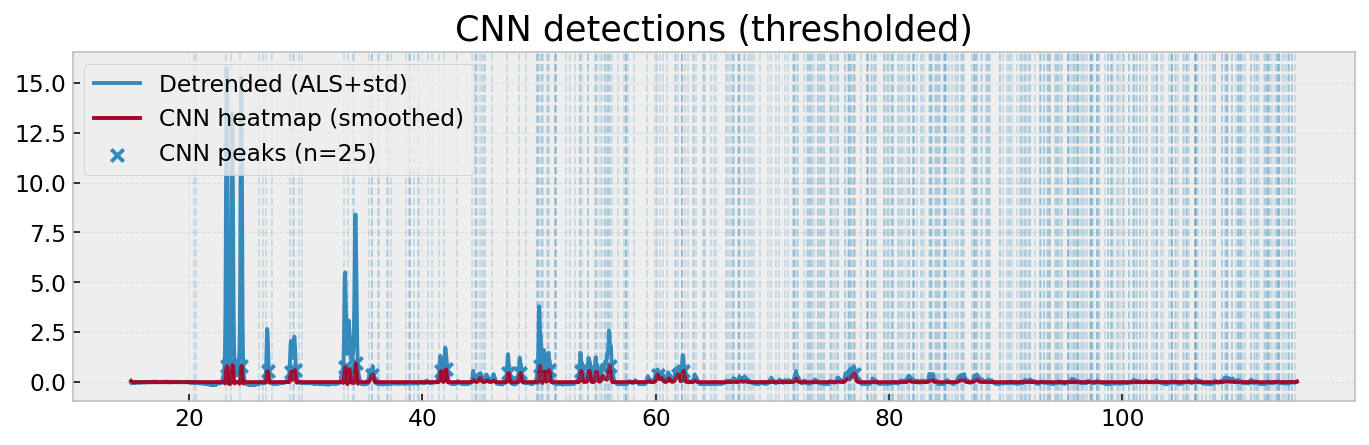

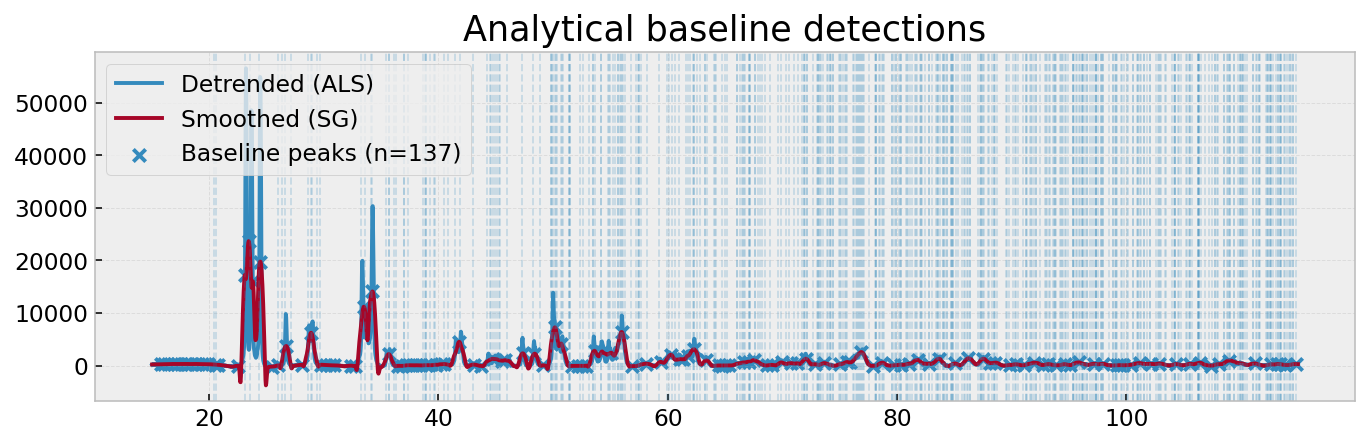

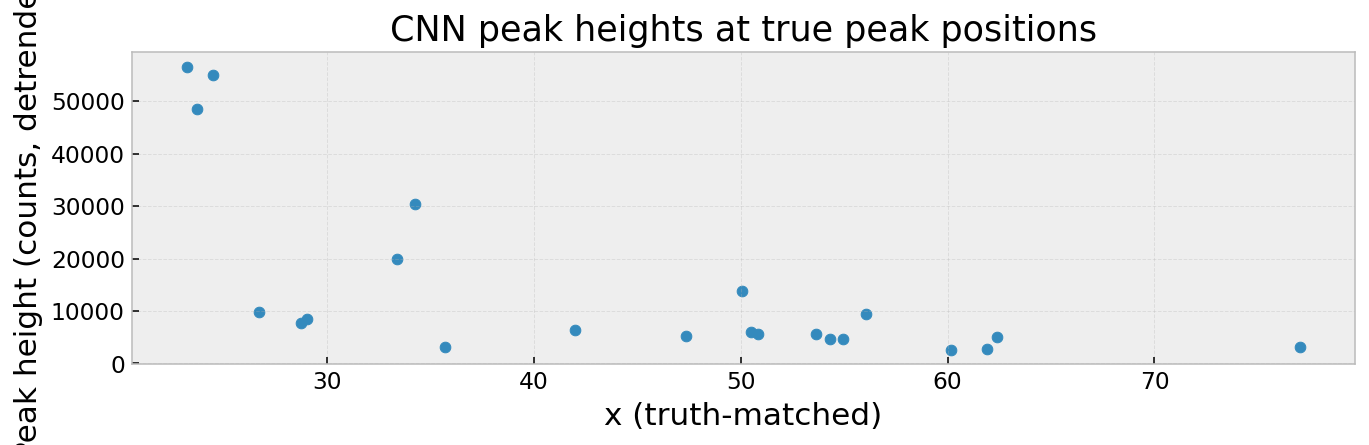

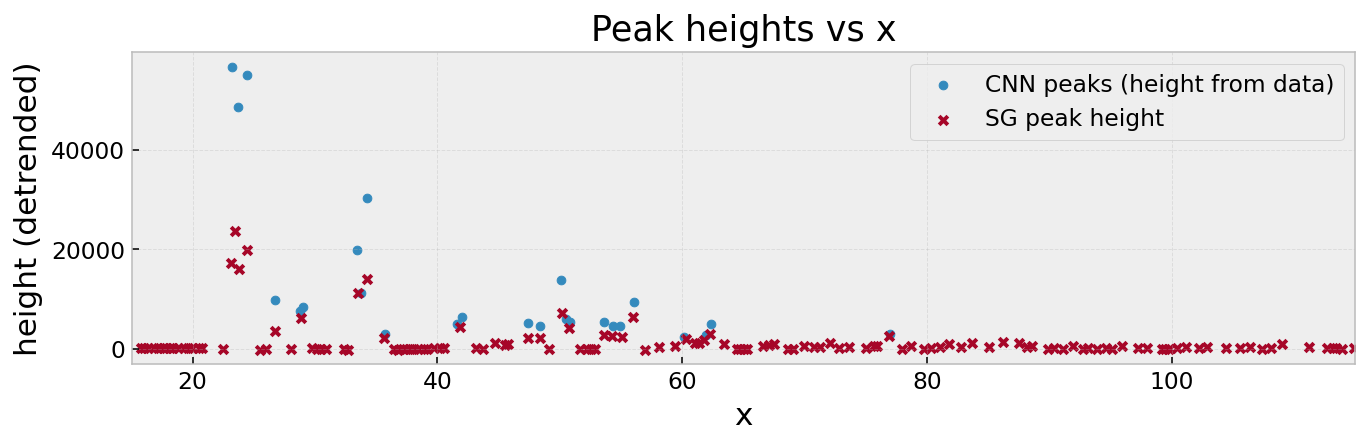

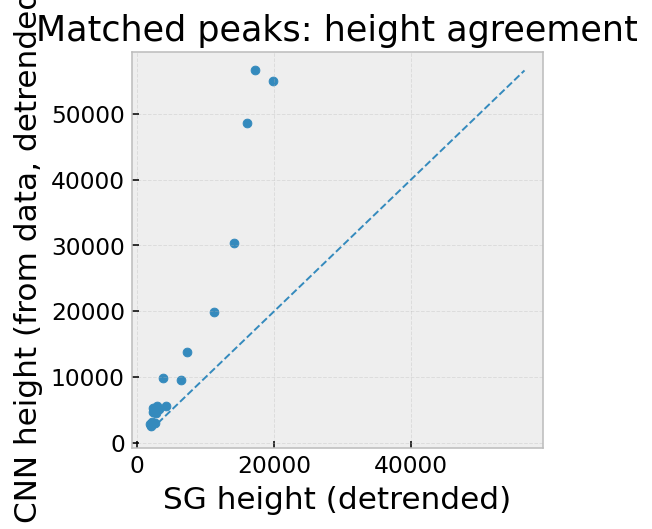

In [44]:
# Wybór urządzenia: GPU (CUDA) jeśli dostępne, w przeciwnym razie CPU
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Using device:", device)

# Długość sygnału (liczba próbek)
L = 2048
# Trening sieci CNN na danych syntetycznych
net = train_cnn(num_steps=300, batch_size=6, L=L, device=device)

# --- Dane testowe (eksperymentalne) ---
x = f.x                 # oś (np. 2θ)
y = f.counts            # intensywność
truth = f.two_theta     # prawdziwe pozycje pików

# --- Inference CNN ---
# Detrening + standaryzacja (tak samo jak w treningu)
y_detr, base = preprocess_for_model(y, standardize=True)
with torch.no_grad():
    # Forward pass przez sieć
    heat_map, height_map = net(
        torch.from_numpy(y_detr).float()
        .unsqueeze(0).unsqueeze(0)
        .to(device)
    )
    # Usunięcie wymiaru batcha
    heat_map = heat_map[0].cpu()
    height_map = height_map[0].cpu()

# Detekcja pików na heatmapie prawdopodobieństw
pred_idx_cnn, heat_props, probs_s = pick_peaks_from_heatmap(
    heat_map,
    min_sep=6,       # minimalna odległość między pikami (w próbkach)
    min_score=0.35,  # minimalne prawdopodobieństwo piku
    min_prom=0.08,   # separacja pików na heatmapie
    smooth_win=9     # wygładzenie heatmapy
)

# --- Metoda klasyczna (baseline) ---
peaks_b, props_b, y_sm, y_det_b = baseline_detect(
    x, y,
    sg_window=31,    # okno Savitzky–Golay
    sg_poly=3,       # stopień wielomianu
    prominence=0.05,# minimalna prominencja piku
    distance=8      # minimalna odległość pików
)

# --- Metryki jakości ---
def match_metrics(x, pred_idx, truth_centers, tol_samples=None, props=None, tol_frac_width=0.5):
    # Zamiana pozycji truth na indeksy próbek
    truth_idx = np.searchsorted(x, truth_centers)
    truth_idx = np.clip(truth_idx, 0, len(x)-1)
    # Automatyczne ustalenie tolerancji dopasowania
    if tol_samples is None:
        if props is not None and len(pred_idx) and "widths" in props:
            W = props["widths"]
            tol_samples = int(max(1, np.round(np.median(W) * tol_frac_width))) if len(W) else max(3, int(0.005*len(x)))
        else:
            tol_samples = max(3, int(0.005*len(x)))
    used=set(); tp=0; errs=[]
    # Dopasowanie predykcji do truth
    for t in truth_idx:
        if len(pred_idx)==0:
            break
        j = int(np.argmin(np.abs(pred_idx - t)))
        if abs(pred_idx[j]-t) <= tol_samples and j not in used:
            used.add(j)
            tp += 1
            errs.append(abs(pred_idx[j]-t))
    # Obliczenie statystyk
    fp = int(len(pred_idx)-tp)
    fn = int(len(truth_idx)-tp)
    P = tp/(tp+fp) if (tp+fp) else 0.0
    R = tp/(tp+fn) if (tp+fn) else 0.0
    F1 = 2*P*R/(P+R) if (P+R) else 0.0
    mae = float(np.mean(errs)) if errs else None
    return dict(tp=tp, fp=fp, fn=fn, precision=P, recall=R, f1=F1, mae=mae, tol_samples=tol_samples)

# Metryki dla CNN i metody klasycznej
metr_cnn = match_metrics(x, pred_idx_cnn, truth)
metr_base = match_metrics(x, peaks_b, truth, props=props_b)
print("CNN metrics     :", metr_cnn)
print("Baseline metrics:", metr_base)

# --- Wizualizacja detekcji CNN ---
plt.figure()
plt.plot(x, y_detr, label="Detrended (ALS+std)")
plt.plot(x, probs_s, label="CNN heatmap (smoothed)")
plt.scatter(x[pred_idx_cnn], probs_s[pred_idx_cnn], marker='x', s=40, label=f"CNN peaks (n={len(pred_idx_cnn)})")
[plt.axvline(c, ls='--', lw=1, alpha=0.2) for c in truth]
plt.legend()
plt.title("CNN detections (thresholded)")
plt.tight_layout()
plt.show()

# --- Wizualizacja metody klasycznej ---
plt.figure()
plt.plot(x, y_det_b, label="Detrended (ALS)")
plt.plot(x, y_sm, label="Smoothed (SG)")
plt.scatter(x[peaks_b], y_sm[peaks_b], marker='x', s=40, label=f"Baseline peaks (n={len(peaks_b)})")
[plt.axvline(c, ls='--', lw=1, alpha=0.2) for c in truth]
plt.legend()
plt.title("Analytical baseline detections")
plt.tight_layout()
plt.show()

# --- Wysokości pików z danych (bez standaryzacji) ---
y_det_raw, _ = preprocess_for_model(y, standardize=False)
h_true = []
for idx in pred_idx_cnn:
    lo = max(0, idx - 3)
    hi = min(len(y_det_raw), idx + 4)
    # Maksimum w otoczeniu piku = wysokość piku
    h_true.append(np.max(y_det_raw[lo:hi]))
h_true = np.array(h_true)
pred_heights_det = h_true
h_cnn = h_true

# --- Dane pomocnicze do porównań ---
sg_heights = props_b.get("peak_heights", y_sm[peaks_b]) if len(peaks_b) else np.array([])
x_sg = x[peaks_b]
x_cnn = x[pred_idx_cnn]

# Tolerancja dopasowania oparta o szerokości pików SG
if len(peaks_b):
    w_res = peak_widths(y_sm, peaks_b, rel_height=0.5)
    widths_samples = w_res[0]
    tol_samples = int(max(3, np.round(np.median(widths_samples) * 0.5)))
else:
    tol_samples = 6

dx = x[1] - x[0]
tol_x = tol_samples * dx

# --- Dopasowanie pików CNN do truth ---
pairs = []
for xi, hi in zip(x_cnn, h_cnn):
    j = int(np.argmin(np.abs(truth - xi)))
    if abs(truth[j] - xi) <= tol_x:
        pairs.append((xi, hi))

if pairs:
    pairs = np.array(pairs)
    plt.figure()
    plt.scatter(pairs[:,0], pairs[:,1], s=30)
    plt.xlabel("x (truth-matched)")
    plt.ylabel("Peak height (counts, detrended)")
    plt.title("CNN peak heights at true peak positions")
    plt.tight_layout()
    plt.show()
else:
    print("No matched CNN peaks to truth within tolerance.")

# --- Wysokości pików vs x (CNN vs SG) ---
plt.figure()
plt.scatter(x_cnn, pred_heights_det, s=20, label="CNN peaks (height from data)")
plt.scatter(x_sg, sg_heights, s=20, marker='x', label="SG peak height")
plt.xlim(x.min(), x.max())
plt.xlabel("x")
plt.ylabel("height (detrended)")
plt.title("Peak heights vs x")
plt.legend()
plt.tight_layout()
plt.show()

# --- Porównanie wysokości CNN vs SG (tylko dopasowane piki) ---
pairs3 = []
for xi, hi in zip(x_cnn, pred_heights_det):
    if len(x_sg) == 0:
        break
    j = int(np.argmin(np.abs(x_sg - xi)))
    if abs(x_sg[j] - xi) <= tol_x:
        pairs3.append((hi, sg_heights[j]))

if pairs3:
    pairs3 = np.array(pairs3)
    lo = float(min(pairs3[:,0].min(), pairs3[:,1].min()))
    hi = float(max(pairs3[:,0].max(), pairs3[:,1].max()))
    plt.figure(figsize=(4.2,4))
    plt.scatter(pairs3[:,1], pairs3[:,0], s=20)
    plt.plot([lo,hi],[lo,hi],'--', lw=1)
    plt.xlabel("SG height (detrended)")
    plt.ylabel("CNN height (from data, detrended)")
    plt.title("Matched peaks: height agreement")
    plt.tight_layout()
    plt.show()
else:
    print("No CNN↔SG matched peaks within tolerance.")


In [45]:

# device = 'cuda' if torch.cuda.is_available() else 'cpu'
# print("Using device:", device)

# L = 2048
# net = train_cnn(num_steps=300, batch_size=6, L=L, device=device)

# # Fresh example
# # x, y, truth = make_signal(n=L, seed=123)
# x = f.x
# y = f.counts
# truth = f.two_theta
# # CNN inference
# y_detr, base = preprocess_for_model(y, standardize=True)
# with torch.no_grad():
#     heat_map, height_map = net(torch.from_numpy(y_detr).float().unsqueeze(0).unsqueeze(0).to(device))
#     heat_map  = heat_map[0].cpu()
#     height_map = height_map[0].cpu()

# pred_idx_cnn, heat_props, probs_s = pick_peaks_from_heatmap(
#     heat_map, min_sep=6, min_score=0.35, min_prom=0.08, smooth_win=9
# )

# # Analytical baseline
# peaks_b, props_b, y_sm, y_det_b = baseline_detect(x, y, sg_window=31, sg_poly=3, prominence=0.05, distance=8)

# # Metrics
# def match_metrics(x, pred_idx, truth_centers, tol_samples=None, props=None, tol_frac_width=0.5):
#     truth_idx = np.searchsorted(x, truth_centers)
#     truth_idx = np.clip(truth_idx, 0, len(x)-1)
#     if tol_samples is None:
#         if props is not None and len(pred_idx) and "widths" in props:
#             W = props["widths"]
#             tol_samples = int(max(1, np.round(np.median(W) * tol_frac_width))) if len(W) else max(3, int(0.005*len(x)))
#         else:
#             tol_samples = max(3, int(0.005*len(x)))
#     used=set(); tp=0; errs=[]
#     for t in truth_idx:
#         if len(pred_idx)==0: break
#         j = int(np.argmin(np.abs(pred_idx - t)))
#         if abs(pred_idx[j]-t) <= tol_samples and j not in used:
#             used.add(j); tp += 1; errs.append(abs(pred_idx[j]-t))
#     fp = int(len(pred_idx)-tp); fn = int(len(truth_idx)-tp)
#     P = tp/(tp+fp) if (tp+fp) else 0.0
#     R = tp/(tp+fn) if (tp+fn) else 0.0
#     F1 = 2*P*R/(P+R) if (P+R) else 0.0
#     mae = float(np.mean(errs)) if errs else None
#     return dict(tp=tp, fp=fp, fn=fn, precision=P, recall=R, f1=F1, mae=mae, tol_samples=tol_samples)

# metr_cnn = match_metrics(x, pred_idx_cnn, truth)
# metr_base = match_metrics(x, peaks_b, truth, props=props_b)
# print("CNN metrics     :", metr_cnn)
# print("Baseline metrics:", metr_base)

# # Plots
# plt.figure()
# plt.plot(x, y_detr, label="Detrended (ALS+std)")
# plt.plot(x, probs_s, label="CNN heatmap (smoothed)")
# plt.scatter(x[pred_idx_cnn], probs_s[pred_idx_cnn], marker='x', s=40, label=f"CNN peaks (n={len(pred_idx_cnn)})")
# [plt.axvline(c, ls='--', lw=1, alpha=0.2) for c in truth]
# plt.legend(); plt.title("CNN detections (thresholded)"); plt.tight_layout(); plt.show()

# plt.figure()
# plt.plot(x, y_det_b, label="Detrended (ALS)")
# plt.plot(x, y_sm, label="Smoothed (SG)")
# plt.scatter(x[peaks_b], y_sm[peaks_b], marker='x', s=40, label=f"Baseline peaks (n={len(peaks_b)})")
# [plt.axvline(c, ls='--', lw=1, alpha=0.2) for c in truth]
# plt.legend(); plt.title("Analytical baseline detections"); plt.tight_layout(); plt.show()


C:\Users\nkurd\AppData\Local\Temp\ipykernel_22492\1869800541.py:12: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  z = spsolve(Z, w * y)


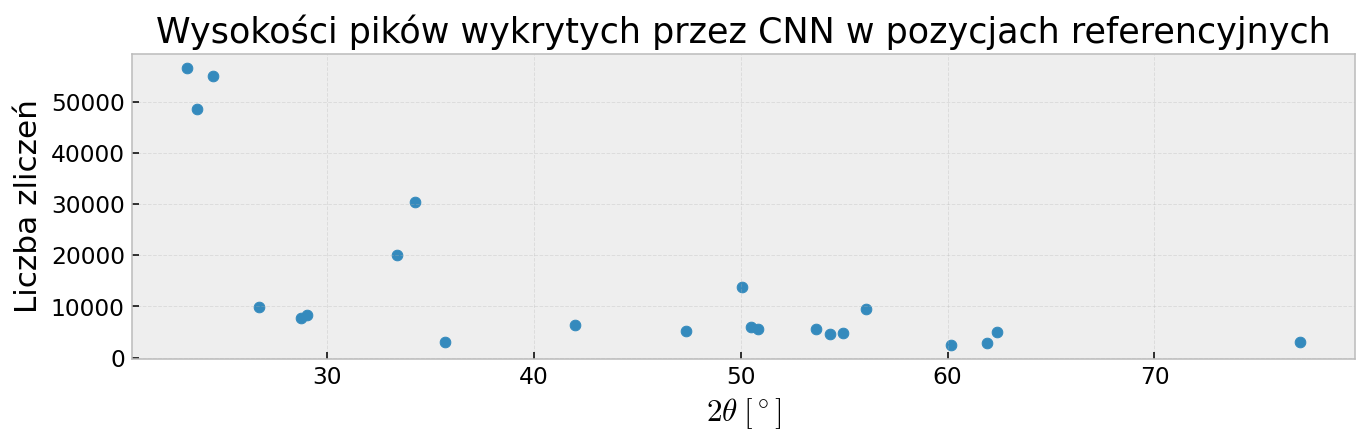

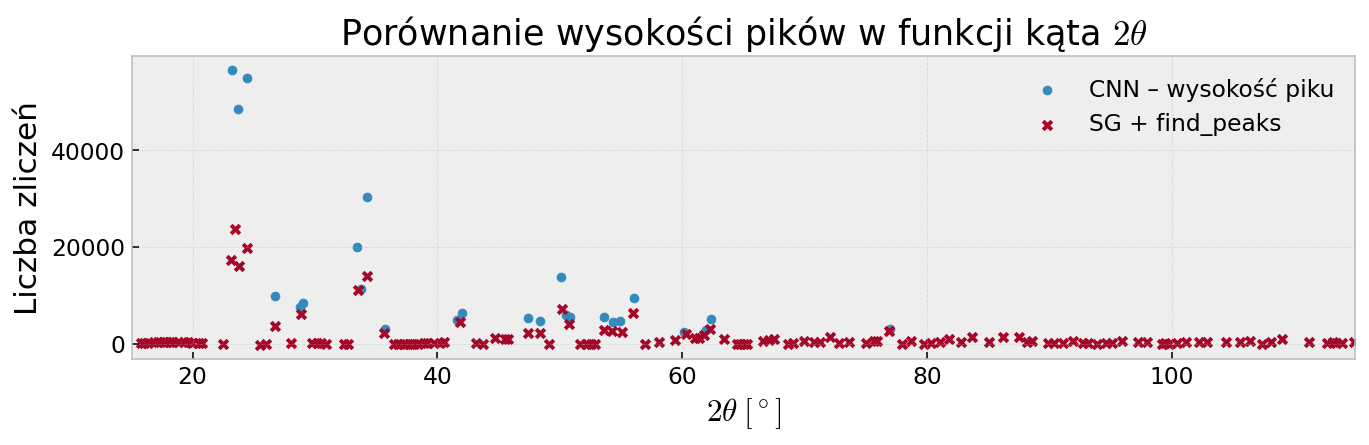

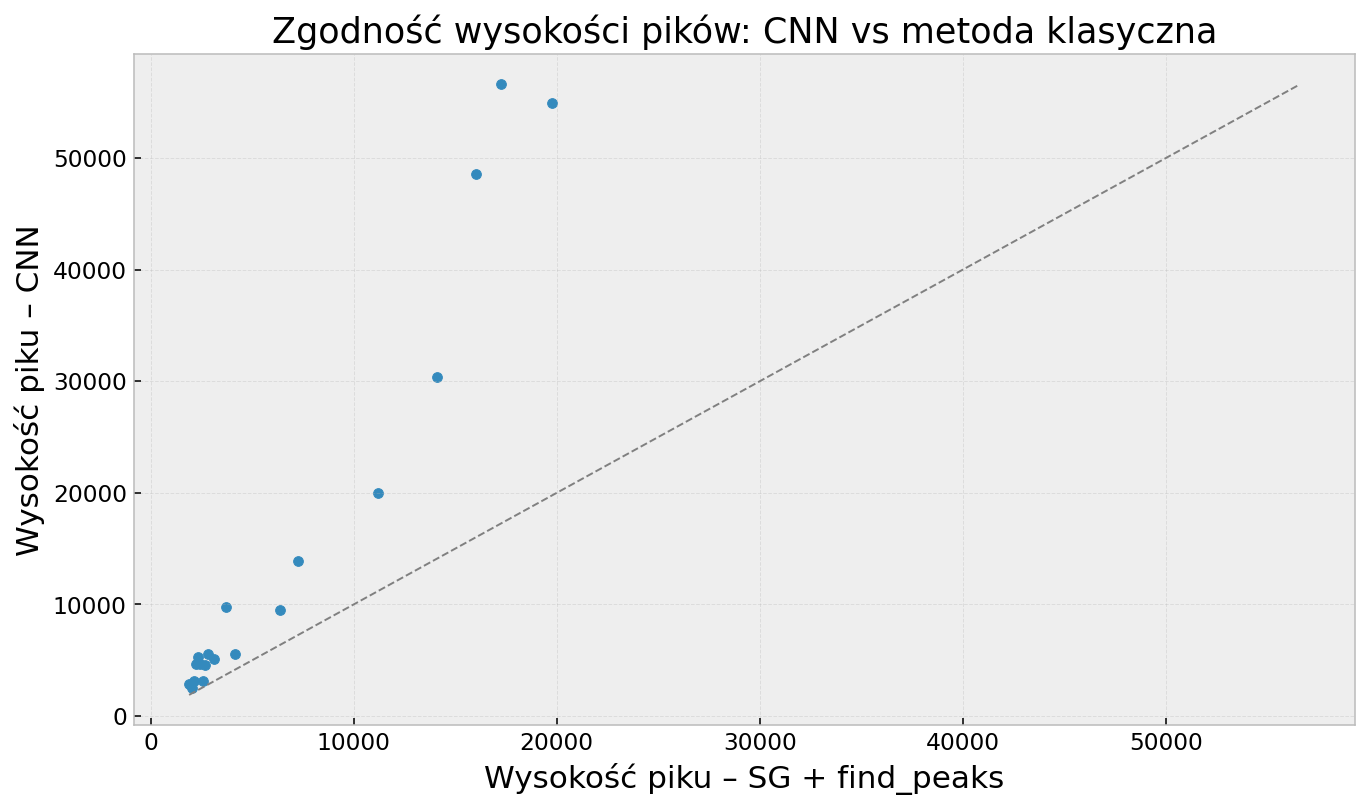

In [46]:
# detrended, but NOT standardized — heights in your data units (counts, detrended)
y_det_raw, _ = preprocess_for_model(y, standardize=False)

h_true = []
for idx in pred_idx_cnn:
    lo = max(0, idx - 3)
    hi = min(len(y_det_raw), idx + 4)
    h_true.append(np.max(y_det_raw[lo:hi]))
h_true = np.array(h_true)

pred_heights_det = h_true   # heights at CNN peaks (from data)
h_cnn = h_true              # keep name used later

# Heights comparison with matching (safe widths via peak_widths)
sg_heights = props_b.get("peak_heights", y_sm[peaks_b]) if len(peaks_b) else np.array([])
x_sg = x[peaks_b]
x_cnn = x[pred_idx_cnn]

if len(peaks_b):
    w_res = peak_widths(y_sm, peaks_b, rel_height=0.5)
    widths_samples = w_res[0]
    tol_samples = int(max(3, np.round(np.median(widths_samples) * 0.5)))
else:
    widths_samples = np.array([])
    tol_samples = 6

dx = x[1] - x[0]
tol_x = tol_samples * dx

# --- Match CNN peaks to truth (positions only) ---
x_truth = truth

pairs = []
for xi, hi in zip(x_cnn, h_cnn):
    j = int(np.argmin(np.abs(x_truth - xi)))
    if abs(x_truth[j] - xi) <= tol_x:
        pairs.append((xi, hi))

if pairs:
    pairs = np.array(pairs)
    x_match = pairs[:, 0]
    h_cnn_m = pairs[:, 1]

    # plt.figure()
    # plt.scatter(x_match, h_cnn_m, s=30)
    # plt.xlabel("x (truth-matched)")
    # plt.ylabel("Peak height (counts, detrended)")
    # plt.title("CNN peak heights at true peak positions (from data)")
    # plt.tight_layout()
    # plt.show()
    plt.figure()
    plt.scatter(x_match, h_cnn_m, s=30)
    plt.xlabel(r"$2\theta\;[^\circ]$")
    plt.ylabel("Liczba zliczeń")
    plt.title("Wysokości pików wykrytych przez CNN w pozycjach referencyjnych")
    plt.tight_layout()
    plt.show()

else:
    print("No matched CNN peaks to truth within tolerance; adjust tol_x or detection thresholds.")


# --- Optional: compare heights vs x for CNN (data-heights) and SG baseline ---
# plt.figure()
# plt.scatter(x_cnn, pred_heights_det, s=20, label="CNN peaks (height from data)")
# plt.scatter(x_sg, sg_heights, s=20, marker='x', label="SG peak height")
# plt.xlim(x.min(), x.max())
# plt.xlabel("x"); plt.ylabel("height (detrended)")
# plt.title("Peak heights vs x")
# plt.legend(); plt.tight_layout(); plt.show()
plt.figure()
plt.scatter(x_cnn, pred_heights_det, s=20, label="CNN – wysokość piku")
plt.scatter(x_sg, sg_heights, s=20, marker='x', label="SG + find_peaks")
plt.xlim(x.min(), x.max())
plt.xlabel(r"$2\theta\;[^\circ]$")
plt.ylabel("Liczba zliczeń")
plt.title("Porównanie wysokości pików w funkcji kąta $2\\theta$")
plt.legend(frameon=False)
plt.tight_layout()
plt.show()





# --- Optional: matched height agreement CNN(data) vs SG (requires 3-col pairs) ---
pairs3 = []
for xi, hi in zip(x_cnn, pred_heights_det):
    if len(x_sg) == 0:
        break
    j = int(np.argmin(np.abs(x_sg - xi)))
    if abs(x_sg[j] - xi) <= tol_x:
        pairs3.append((xi, hi, sg_heights[j]))

if pairs3:
    pairs3 = np.array(pairs3)
    h_cnn_m2 = pairs3[:, 1]
    h_sg_m   = pairs3[:, 2]

    lo = float(min(h_cnn_m2.min(), h_sg_m.min()))
    hi = float(max(h_cnn_m2.max(), h_sg_m.max()))
   
    plt.figure(figsize=(10,6))

    plt.scatter(h_sg_m, h_cnn_m2, s=25)
    plt.plot([lo, hi], [lo, hi], '--', lw=1, color='gray')

    plt.xlabel("Wysokość piku – SG + find_peaks")
    plt.ylabel("Wysokość piku – CNN")
    plt.title("Zgodność wysokości pików: CNN vs metoda klasyczna")

    plt.tight_layout()
    plt.show()

else:
    print("No CNN↔SG matched peaks within tolerance (for height agreement plot).")


In [47]:

# # Heights comparison with matching (safe widths via peak_widths)
# pred_heights_det = height_map[pred_idx_cnn].numpy()
# sg_heights = props_b.get("peak_heights", y_sm[peaks_b]) if len(peaks_b) else np.array([])
# x_sg = x[peaks_b]
# x_cnn = x[pred_idx_cnn]

# if len(peaks_b):
#     w_res = peak_widths(y_sm, peaks_b, rel_height=0.5)
#     widths_samples = w_res[0]
#     tol_samples = int(max(3, np.round(np.median(widths_samples) * 0.5)))
# else:
#     widths_samples = np.array([])
#     tol_samples = 6

# dx = x[1] - x[0]
# tol_x = tol_samples * dx

# pairs = []
# for xi, hi in zip(x_cnn, pred_heights_det):
#     if len(x_sg) == 0:
#         break
#     j = int(np.argmin(np.abs(x_sg - xi)))
#     if abs(x_sg[j] - xi) <= tol_x:
#         pairs.append((xi, hi, sg_heights[j]))

# if pairs:
#     pairs = np.array(pairs)
#     x_match, h_cnn_m, h_sg_m = pairs[:,0], pairs[:,1], pairs[:,2]

#     plt.figure()
#     plt.scatter(x_cnn, pred_heights_det, s=20, label="CNN (detrended height)")
#     plt.scatter(x_sg, sg_heights, s=20, marker='x', label="SG peak height")
#     plt.xlim(0, 1)
#     plt.xlabel("x (domain)"); plt.ylabel("height (detrended)")
#     plt.title("Peak heights vs x")
#     plt.legend(); plt.tight_layout(); plt.show()

#     lo = float(min(h_cnn_m.min(), h_sg_m.min()))
#     hi = float(max(h_cnn_m.max(), h_sg_m.max()))
#     plt.figure(figsize=(4.2,4))
#     plt.scatter(h_sg_m, h_cnn_m, s=20)
#     plt.plot([lo,hi],[lo,hi],'--', lw=1)
#     plt.xlabel("SG height (detrended)")
#     plt.ylabel("CNN height (detrended)")
#     plt.title("Matched peaks: height agreement")
#     plt.tight_layout(); plt.show()
# else:
#     print("No matched peaks within tolerance; adjust thresholds or tolerance if needed.")


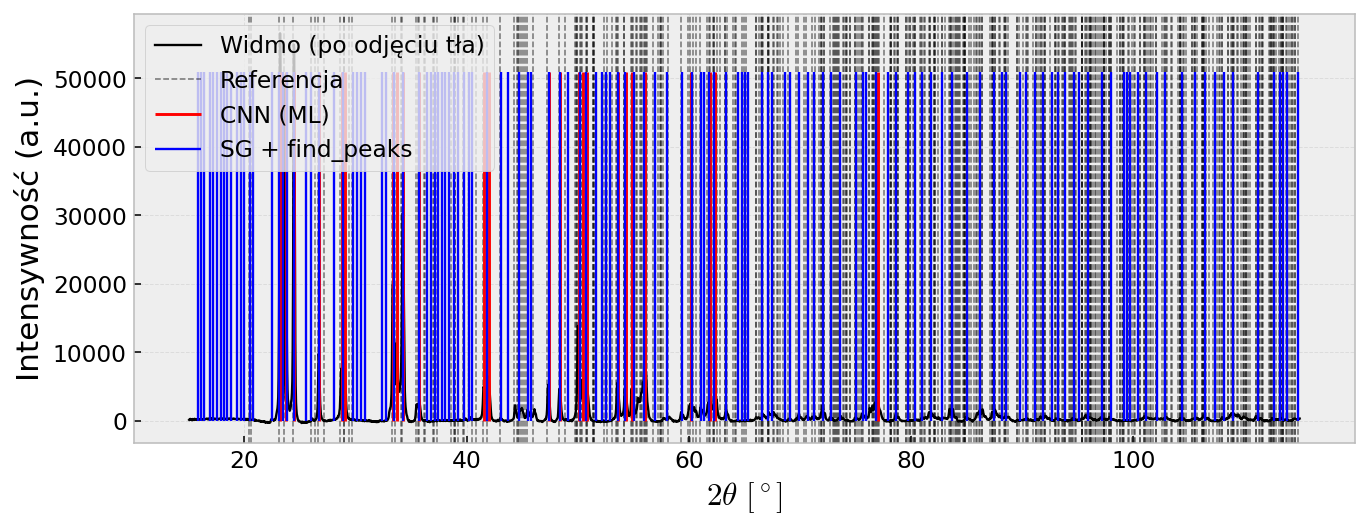

In [48]:
plt.figure(figsize=(10,4))
plt.plot(x, y_det_raw, color='black', lw=1.2, label="Widmo (po odjęciu tła)")

for c in truth:
    plt.axvline(c, color='black', ls='--', lw=0.8, alpha=0.5, label="Referencja" if c==truth[0] else "")

plt.vlines(x[pred_idx_cnn], ymin=0, ymax=np.max(y_det_raw)*0.9,
           color='red', lw=1.5, label="CNN (ML)")

plt.vlines(x[peaks_b], ymin=0, ymax=np.max(y_det_raw)*0.9,
           color='blue', lw=1.2, label="SG + find_peaks")

plt.xlabel(r"$2\theta\ [^\circ]$")
plt.ylabel("Intensywność (a.u.)")
plt.legend()
plt.tight_layout()
plt.show()


In [49]:
# errors_deg = np.abs(x[pred_idx_cnn] - truth[np.searchsorted(truth, x[pred_idx_cnn], side="left")])

# plt.figure()
# plt.hist(errors_deg, bins=10, edgecolor="black")
# plt.xlabel(r"$|\Delta 2\theta|\;[^\circ]$")
# plt.ylabel("Liczba pików")
# plt.title("Rozkład błędu lokalizacji pików – CNN")
# plt.tight_layout()
# plt.show()

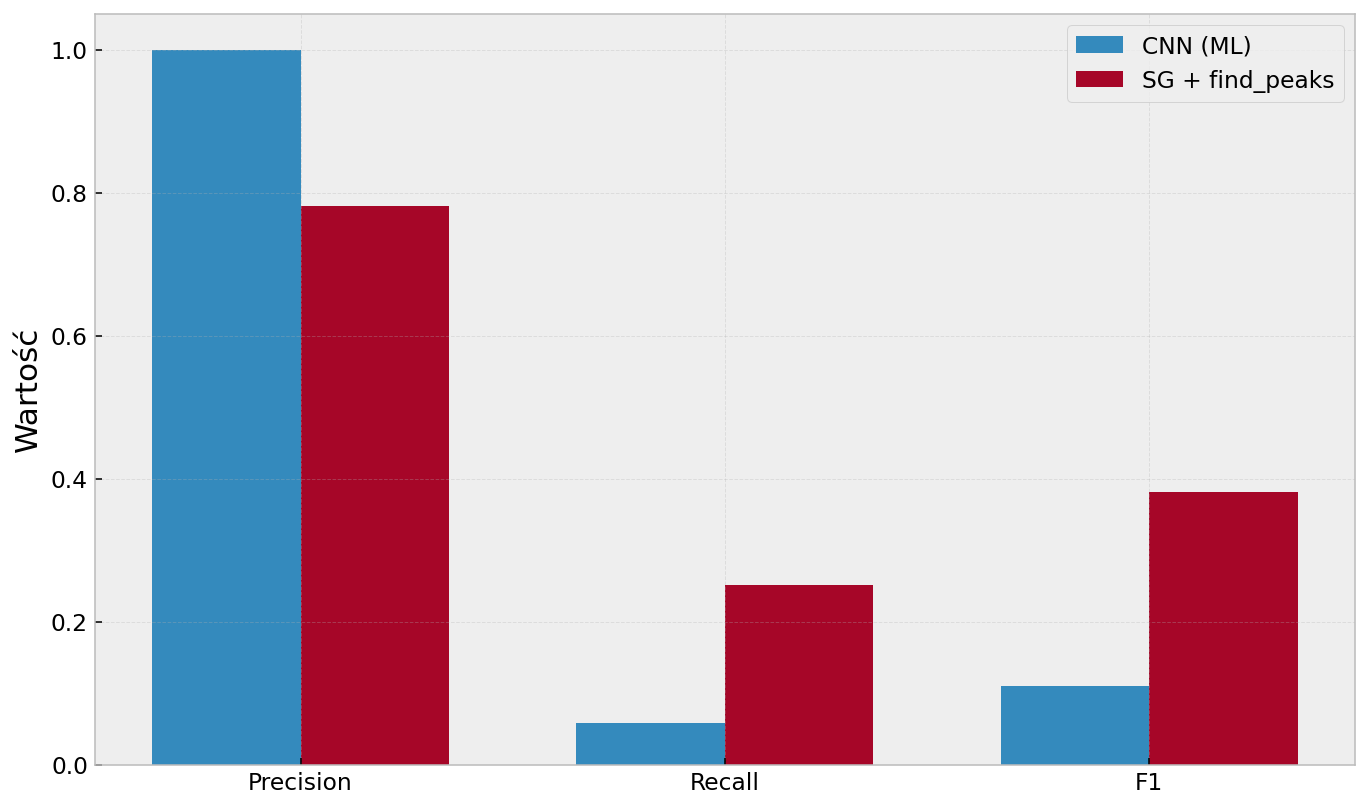

In [50]:
labels = ["Precision", "Recall", "F1"]
cnn_vals = [metr_cnn[k] for k in ["precision","recall","f1"]]
base_vals = [metr_base[k] for k in ["precision","recall","f1"]]

xpos = np.arange(len(labels))
w = 0.35

# plt.figure(figsize=(6,4))
plt.figure(figsize=(10, 6))

plt.bar(xpos-w/2, cnn_vals, width=w, label="CNN (ML)")
plt.bar(xpos+w/2, base_vals, width=w, label="SG + find_peaks")

plt.xticks(xpos, labels)
plt.ylabel("Wartość")
plt.ylim(0,1.05)
plt.legend()
plt.tight_layout()
plt.show()


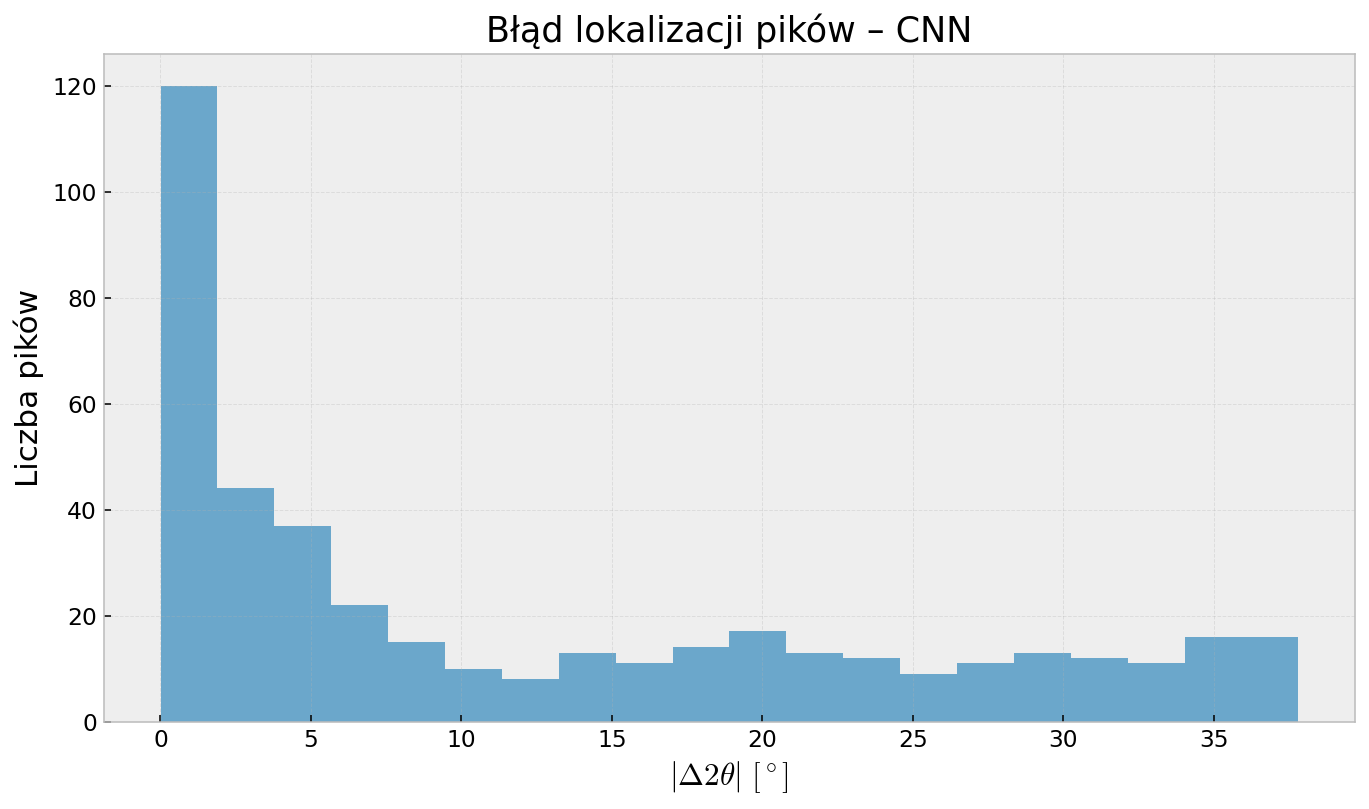

In [51]:
errs_cnn = []
for t in truth:
    j = np.argmin(np.abs(x[pred_idx_cnn] - t))
    errs_cnn.append(abs(x[pred_idx_cnn][j] - t))

# plt.figure(figsize=(6,4))
plt.figure(figsize=(10, 6))

plt.hist(errs_cnn, bins=20, alpha=0.7)
plt.xlabel(r"$|\Delta 2\theta|\ [^\circ]$")
plt.ylabel("Liczba pików")
plt.title("Błąd lokalizacji pików – CNN")
plt.tight_layout()
plt.show()


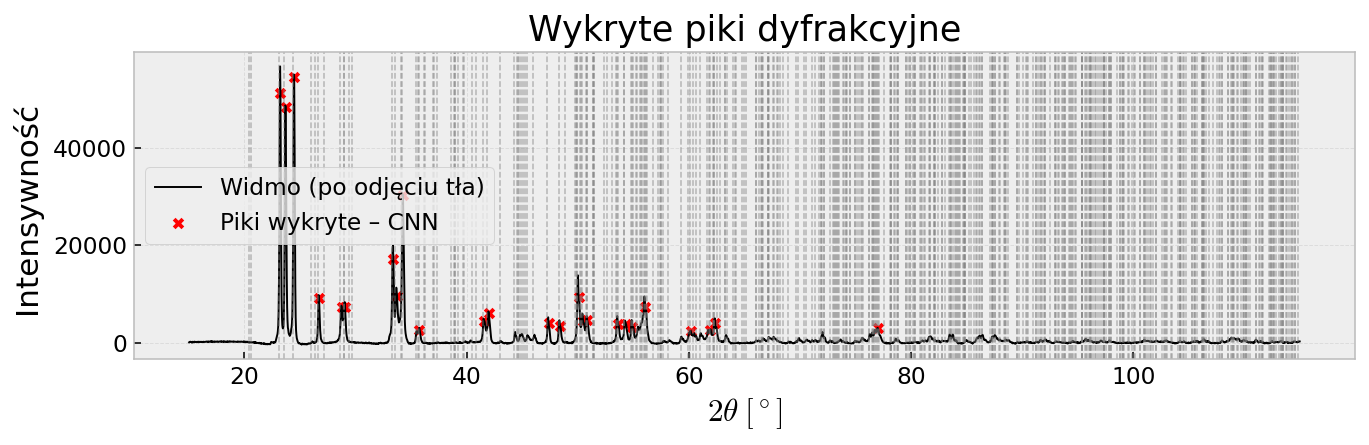

In [52]:
plt.figure()

# widmo
plt.plot(x, y_det_b, color="black", lw=1.0, label="Widmo (po odjęciu tła)")
# plt.plot(x,y)
# piki referencyjne
for c in truth:
    plt.axvline(c, color="gray", lw=0.8, ls="--", alpha=0.5)

# piki CNN
plt.scatter(
    x[pred_idx_cnn],
    y_det_b[pred_idx_cnn],
    s=20,
    color="red",
    marker="x",
    label="Piki wykryte – CNN"
)
# plt.scatter(
#     x[pred_idx_cnn],
#     y[pred_idx_cnn],
#     s=20,
#     color="green",
#     marker="x",
#     label="Piki wykryte – CNN"
# )
# plt.xlim(31,35)
plt.xlabel(r"$2\theta\;[^\circ]$")
plt.ylabel("Intensywność ")
plt.title("Wykryte piki dyfrakcyjne")
plt.legend()
plt.tight_layout()
plt.show()


In [53]:
print(pred_idx_cnn)
print(y_det_b[pred_idx_cnn])
print(y[pred_idx_cnn])


[ 246  260  283  350  411  420  550  560  576  619  795  807  968  999
 1049 1061 1072 1155 1176 1194 1228 1351 1403 1417 1855]
[51152.52766662 48313.9109456  54407.30178383  9190.68619889
  7282.2736328   7335.82838934 17201.4166847   9619.04176732
 30353.48528852  2726.04116305  4520.01309174  6163.40470755
  4172.21252837  3414.73065409  9468.69810353  4582.86751452
  4730.8865619   3932.80236705  3995.51390065  3269.9825282
  7434.23097543  2496.30698147  2622.44642598  4194.13552968
  3041.8258503 ]
[53808. 51060. 57079. 11262.  9195.  9232. 19675. 12146. 32895.  4983.
  6515.  8162.  6208.  5535. 11669.  6767.  6888.  6134.  6266.  5563.
  9651.  4731.  4908.  6435.  5103.]


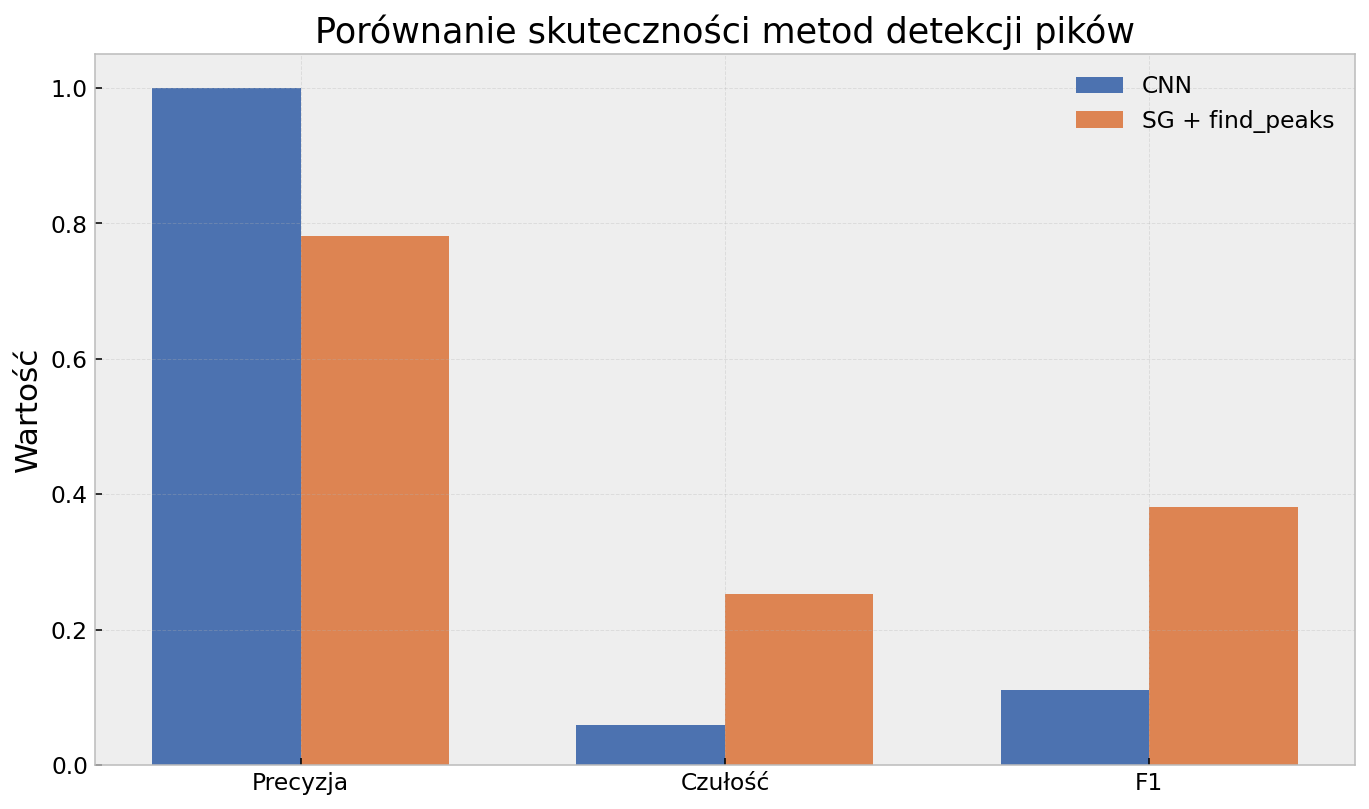

In [54]:
labels = ["Precyzja", "Czułość", "F1"]
cnn_vals = [metr_cnn["precision"], metr_cnn["recall"], metr_cnn["f1"]]
sg_vals  = [metr_base["precision"], metr_base["recall"], metr_base["f1"]]

xpos = np.arange(len(labels))
w = 0.35

# plt.figure()
plt.figure(figsize=(10, 6))
plt.bar(xpos - w/2, cnn_vals, w, label="CNN", color="#4C72B0")
plt.bar(xpos + w/2, sg_vals,  w, label="SG + find_peaks", color="#DD8452")

plt.xticks(xpos, labels)
plt.ylabel("Wartość")
plt.ylim(0, 1.05)
plt.title("Porównanie skuteczności metod detekcji pików")
plt.legend(frameon=False)
plt.tight_layout()
plt.show()
